In [16]:
import pandas as pd
import glob
import os

# 1. 경로 설정
base_path = "outputs/"

# 2. 분석할 실험 폴더 순서 지정
experiment_folders = [
    '0811-150-200','0902-150-200', '0903-150-200',
    '0806-150-300', '0812-150-400','0807-150-600', '0820-150-600',
    '0814-200-100','0811-200-200', '0815-500-400',
    '0819-50-200', '0819-50-200-2', '0819-50-200-3','0822-50-200',
    '0821-50-600', '0825-50-600_9b08r','0827-50-600'
]

all_results = []

# 3. 각 폴더에서 결과 파일 읽어오기
for folder in experiment_folders:
    file_path = os.path.join(base_path, folder, folder, "mpnn_results.csv")
    try:
        df = pd.read_csv(file_path)
        df['experiment'] = folder
        all_results.append(df)
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file_path}")

# 4. 모든 데이터프레임을 하나로 합치기
master_df = pd.concat(all_results, ignore_index=True)

# 'experiment' 컬럼을 Categorical 타입으로 변환하여 순서를 저장합니다.
master_df['experiment'] = pd.Categorical(master_df['experiment'],
                                       categories=experiment_folders,
                                       ordered=True)
# ------------------------------------

# 5. 합쳐진 데이터를 하나의 CSV 파일로 저장
master_df.to_csv("all_experiments_summary.csv", index=False)

print("모든 실험 결과가 'all_experiments_summary.csv' 파일로 통합되었습니다.")
print(master_df.head())

모든 실험 결과가 'all_experiments_summary.csv' 파일로 통합되었습니다.
   Unnamed: 0  design  n      mpnn     plddt     i_ptm      i_pae       rmsd  \
0           0       0  0  1.239399  0.694146  0.075753  26.362641  49.123158   
1           1       0  1  1.199185  0.720313  0.055994  27.506520  34.398735   
2           2       0  2  1.252676  0.601631  0.079683  26.382344  24.085018   
3           3       0  3  1.209843  0.760076  0.072424  26.148674  31.081024   
4           4       0  4  1.182443  0.764199  0.057937  27.768920  50.634804   

                                                 seq    experiment  
0  GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFT...  0811-150-200  
1  GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFT...  0811-150-200  
2  GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFT...  0811-150-200  
3  GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFT...  0811-150-200  
4  GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFT...  0811-150-200  


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# CSV를 읽으면 Categorical 정보도 함께 로드됩니다.
master_df = pd.read_csv("all_experiments_summary.csv")
# 'experiment' 컬럼을 다시 Categorical 타입으로 명시해주는 것이 안전합니다.
exp_order_from_file = master_df['experiment'].unique().tolist()
master_df['experiment'] = pd.Categorical(master_df['experiment'], categories=exp_order_from_file, ordered=True)

# 그래프 스타일 설정
sns.set(style="whitegrid", context="talk")

# 분석할 퍼센타일 목록
percentiles_to_analyze = [1, 0.20, 0.10, 0.01]

for p in percentiles_to_analyze:
    
    def get_top_percent(group, percentile):
        n = int(len(group) * percentile)
        if n < 1: n = 1
        return group.nsmallest(n, 'rmsd')

    # 각 퍼센타일별로 상위 데이터를 필터링하는 부분은 그대로 유지합니다.
    top_df = master_df.groupby('experiment', group_keys=False, observed=False).apply(lambda g: get_top_percent(g, p))
    
    # --- ✨ 여기가 요청하신 기능입니다 ✨ ---
    # boxplot 대신 평균과 표준편차를 계산합니다.
    
    print(f"--- [ 요약 통계: RMSD 기준 상위 {p*100:.2f}% ] ---")
    
    if top_df.empty:
        print("해당 조건에 맞는 데이터가 없습니다.")
        continue # 다음 루프로 넘어갑니다.

    # groupby와 agg를 사용해 각 지표의 평균과 표준편차를 한번에 계산
    summary_stats = top_df.groupby('experiment', observed=False).agg(
        rmsd_mean=('rmsd', 'mean'),
        rmsd_std=('rmsd', 'std'),
        i_pae_mean=('i_pae', 'mean'),
        i_pae_std=('i_pae', 'std'),
        plddt_mean=('plddt', 'mean'),
        plddt_std=('plddt', 'std')
    ).round(3) # 소수점 3자리까지 반올림
    
    # 결과를 표 형태로 출력
    print(summary_stats)
    print("\n" + "="*80 + "\n") # 각 표를 구분하기 위한 줄

--- [ 요약 통계: RMSD 기준 상위 100.00% ] ---
                   rmsd_mean  rmsd_std  i_pae_mean  i_pae_std  plddt_mean  \
experiment                                                                  
0811-150-200          48.532    17.757      26.353      2.580       0.766   
0902-150-200          49.593    17.588      26.600      1.827       0.761   
0903-150-200          48.465    15.783      26.528      2.040       0.773   
0806-150-300          52.112    15.883      26.923      1.871       0.770   
0812-150-400          48.287    15.102      26.581      1.931       0.767   
0807-150-600          48.499    16.043      26.591      1.992       0.772   
0820-150-600          48.203    16.221      26.484      2.138       0.772   
0814-200-100          49.159    16.503      26.613      2.309       0.763   
0811-200-200          50.255    18.106      26.477      2.410       0.778   
0815-500-400          51.533    16.463      26.809      1.845       0.768   
0819-50-200           44.644    14.097

/tmp/ipykernel_556628/35854035.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False, observed=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/35854035.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False, observed=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/35

/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

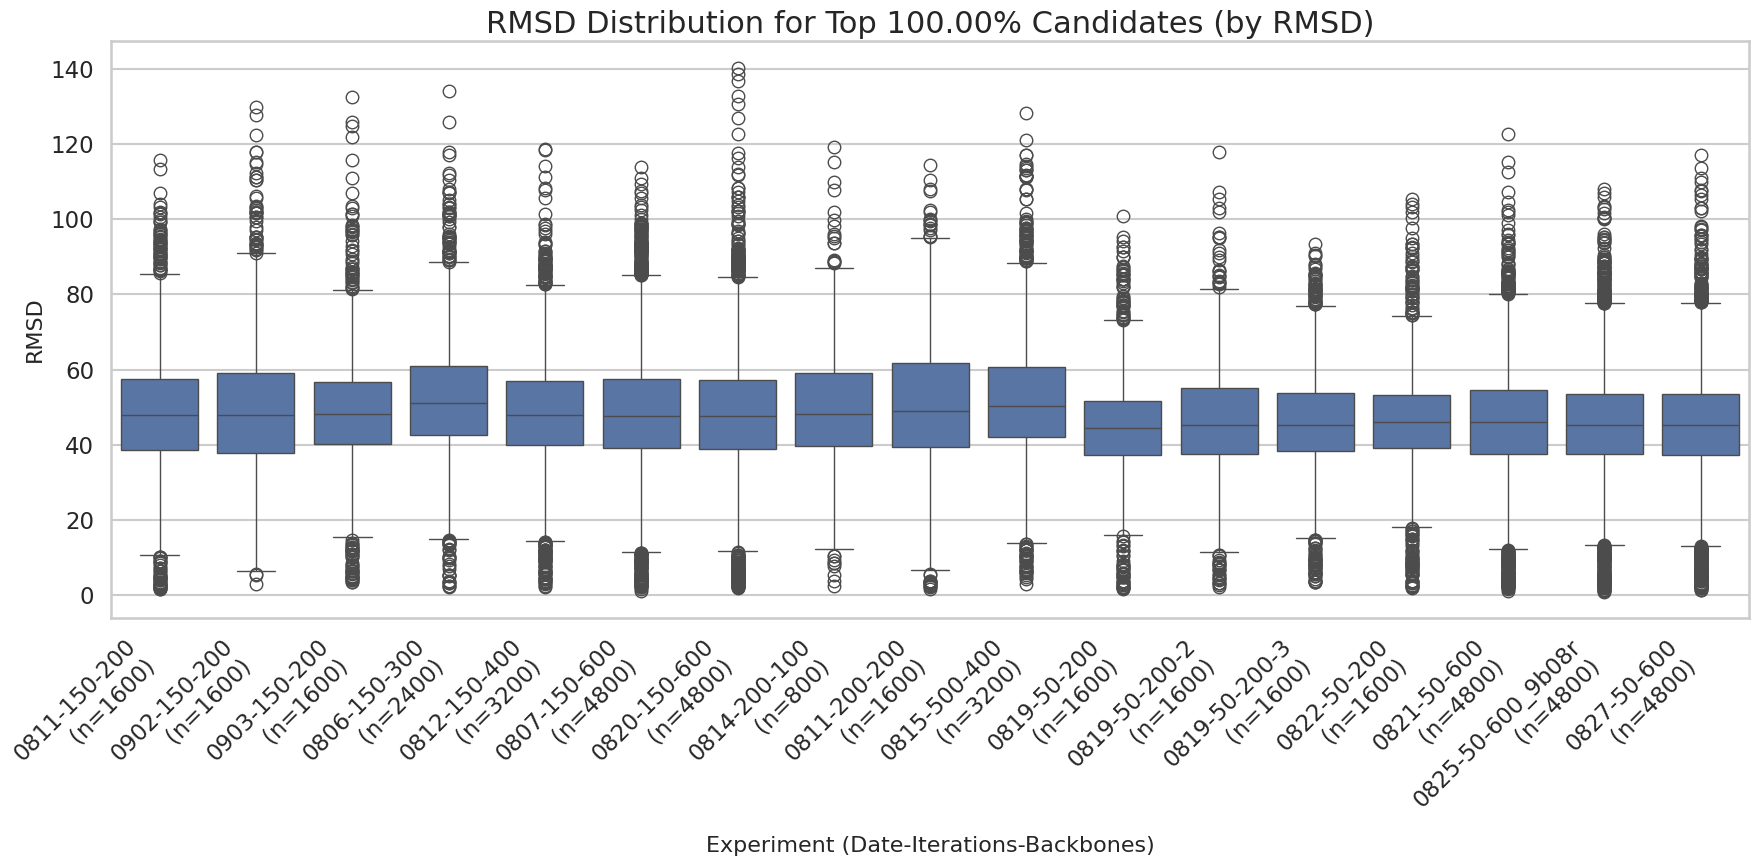

/tmp/ipykernel_556628/4192487576.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_ipae.set_xticklabels(new_labels)


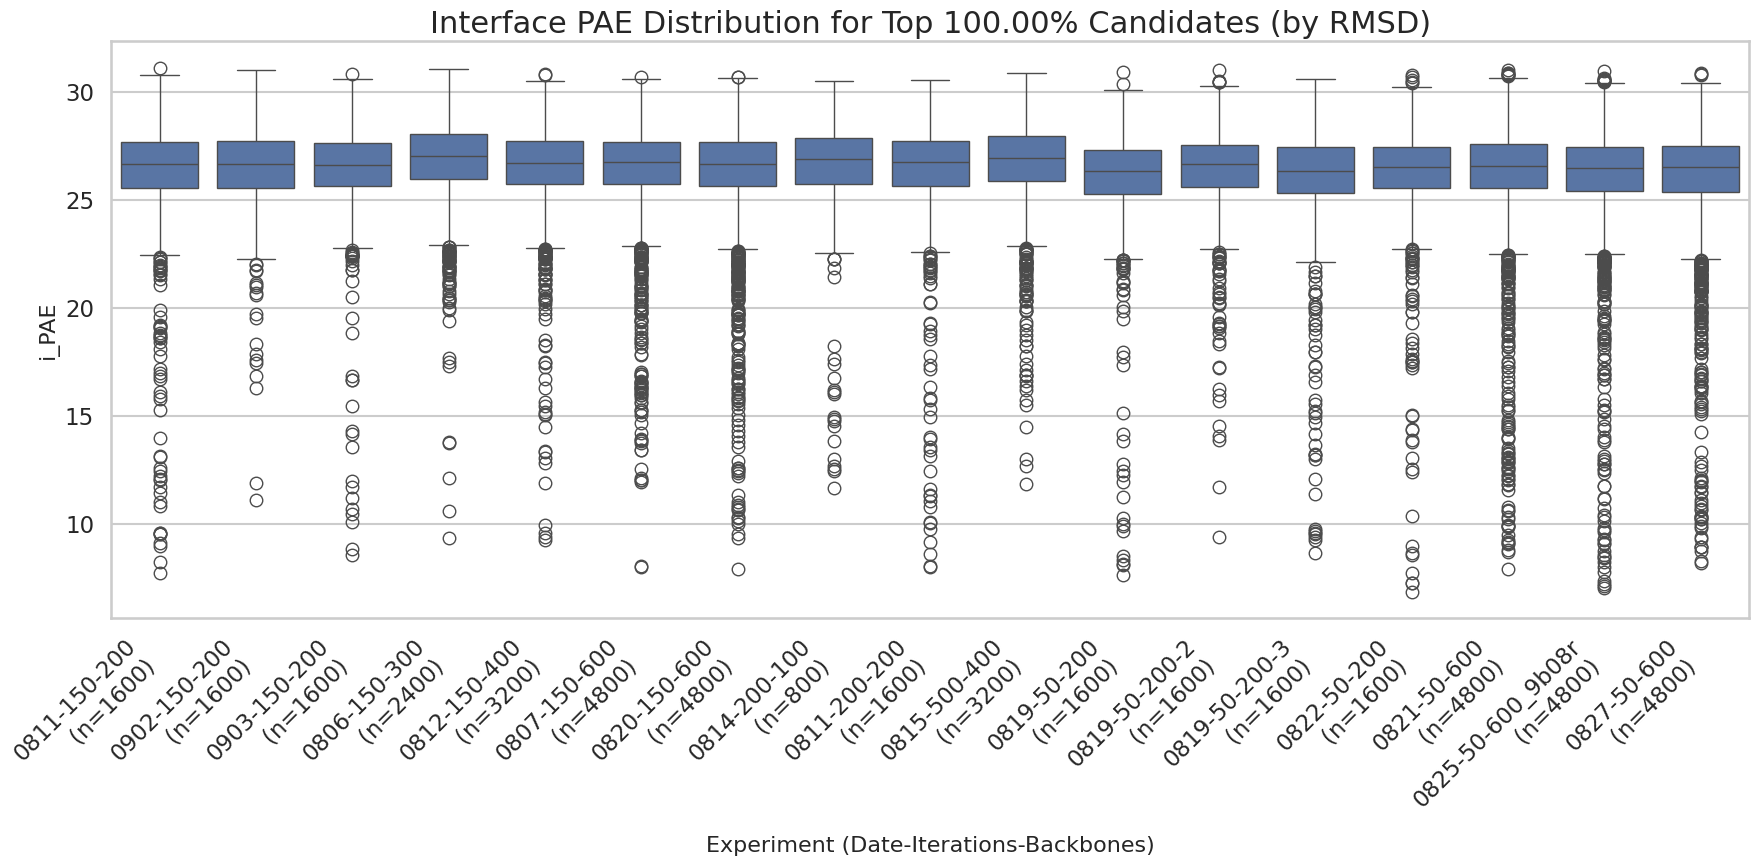

/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

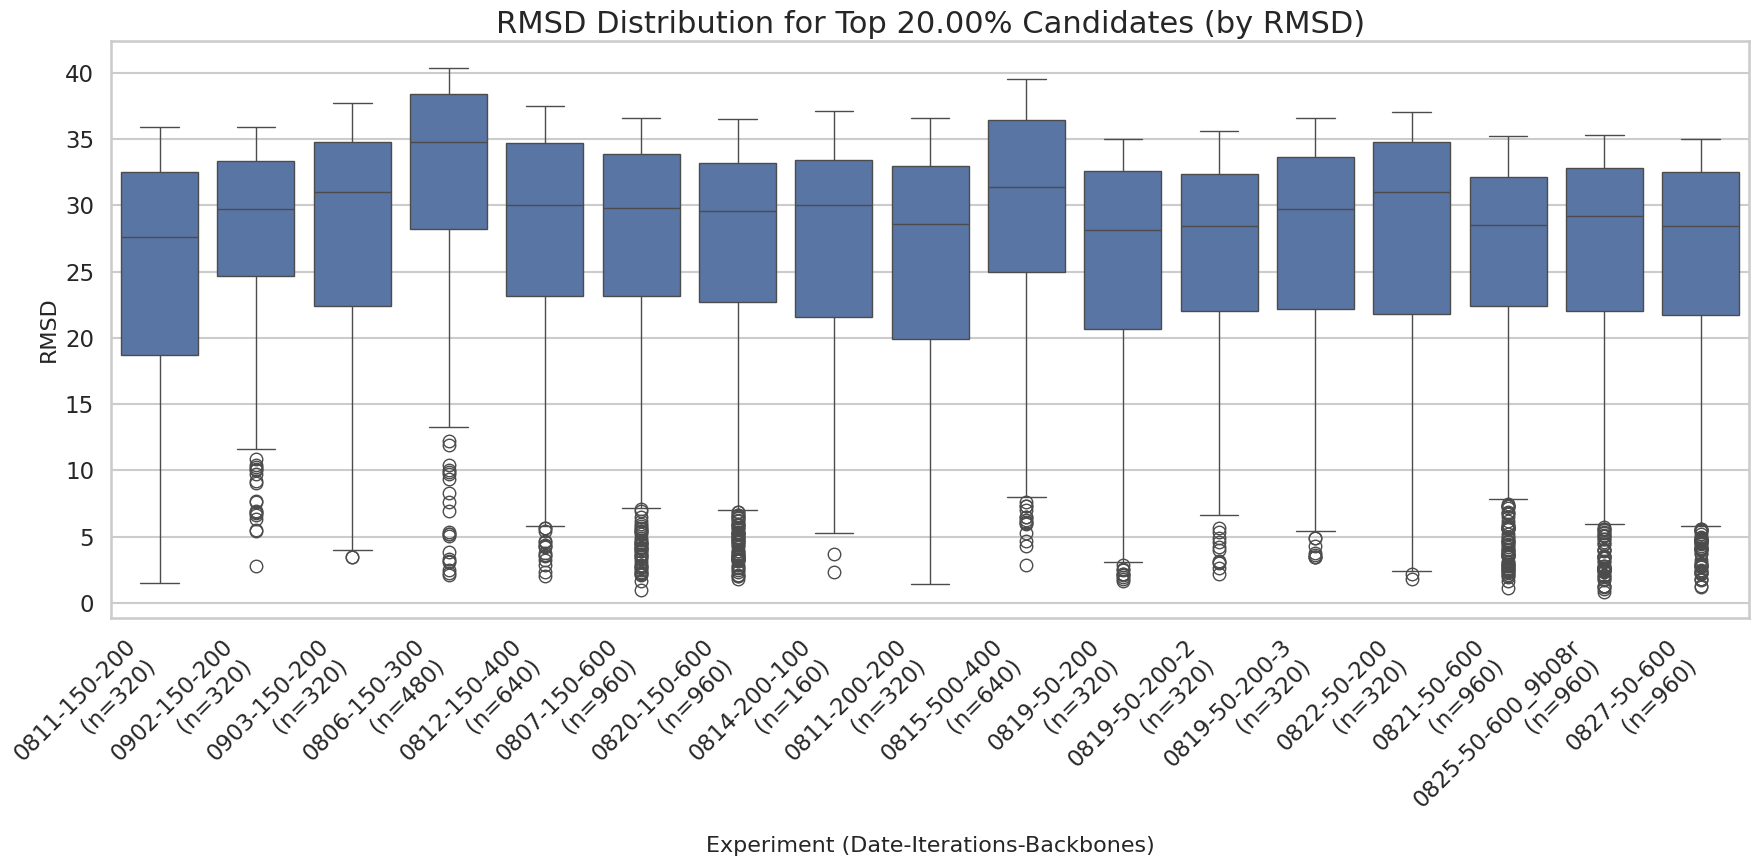

/tmp/ipykernel_556628/4192487576.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_ipae.set_xticklabels(new_labels)


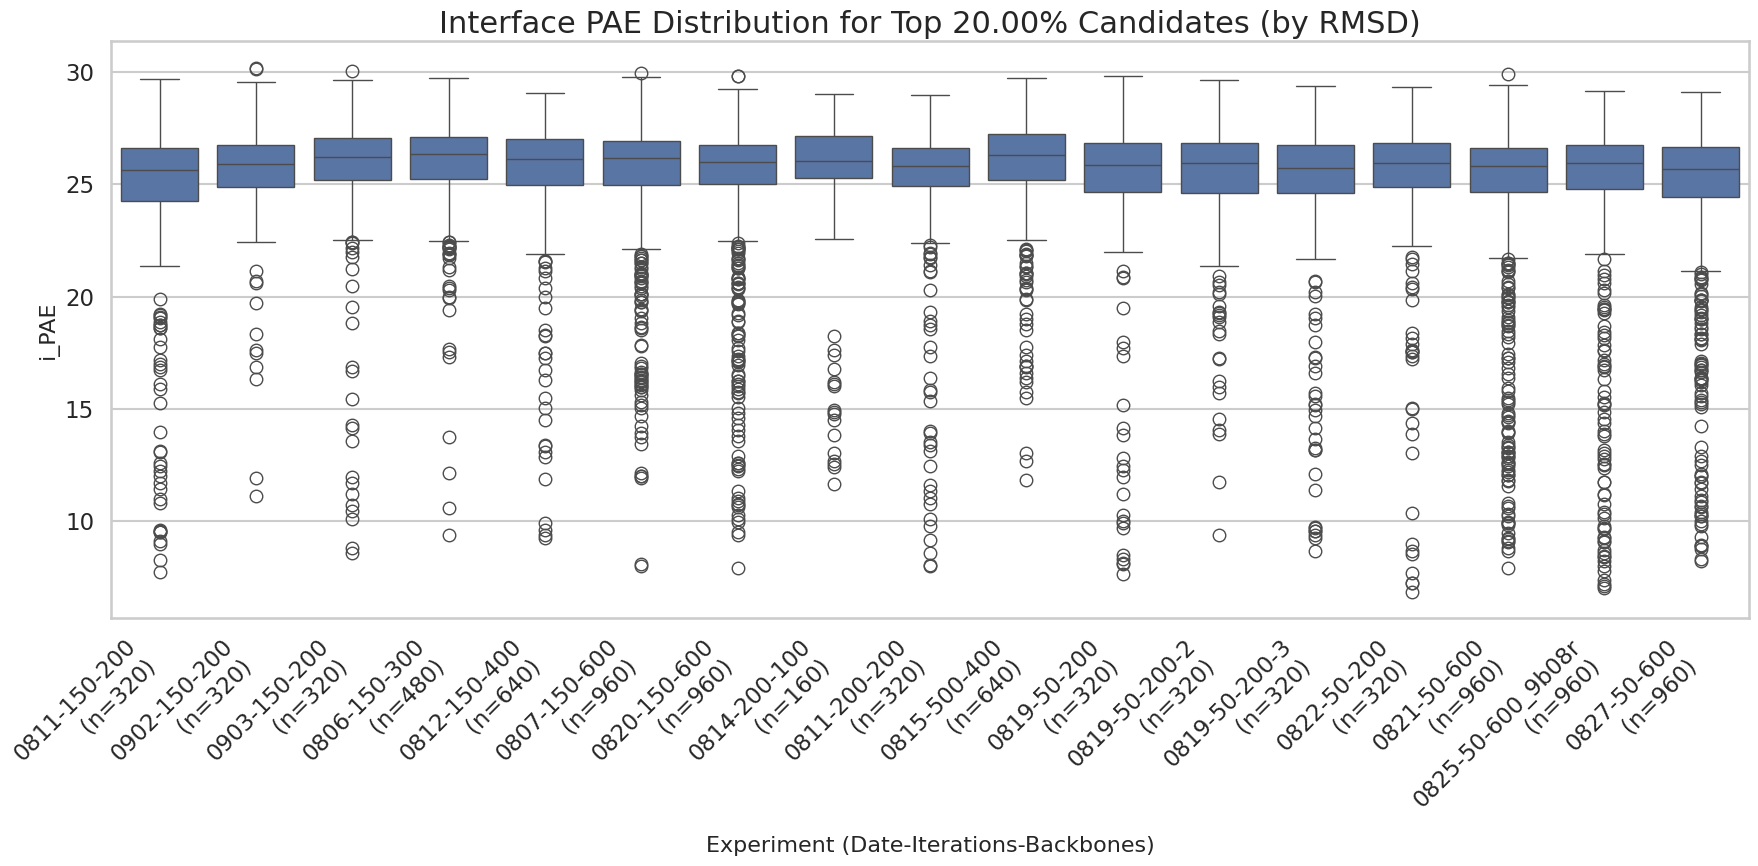

/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

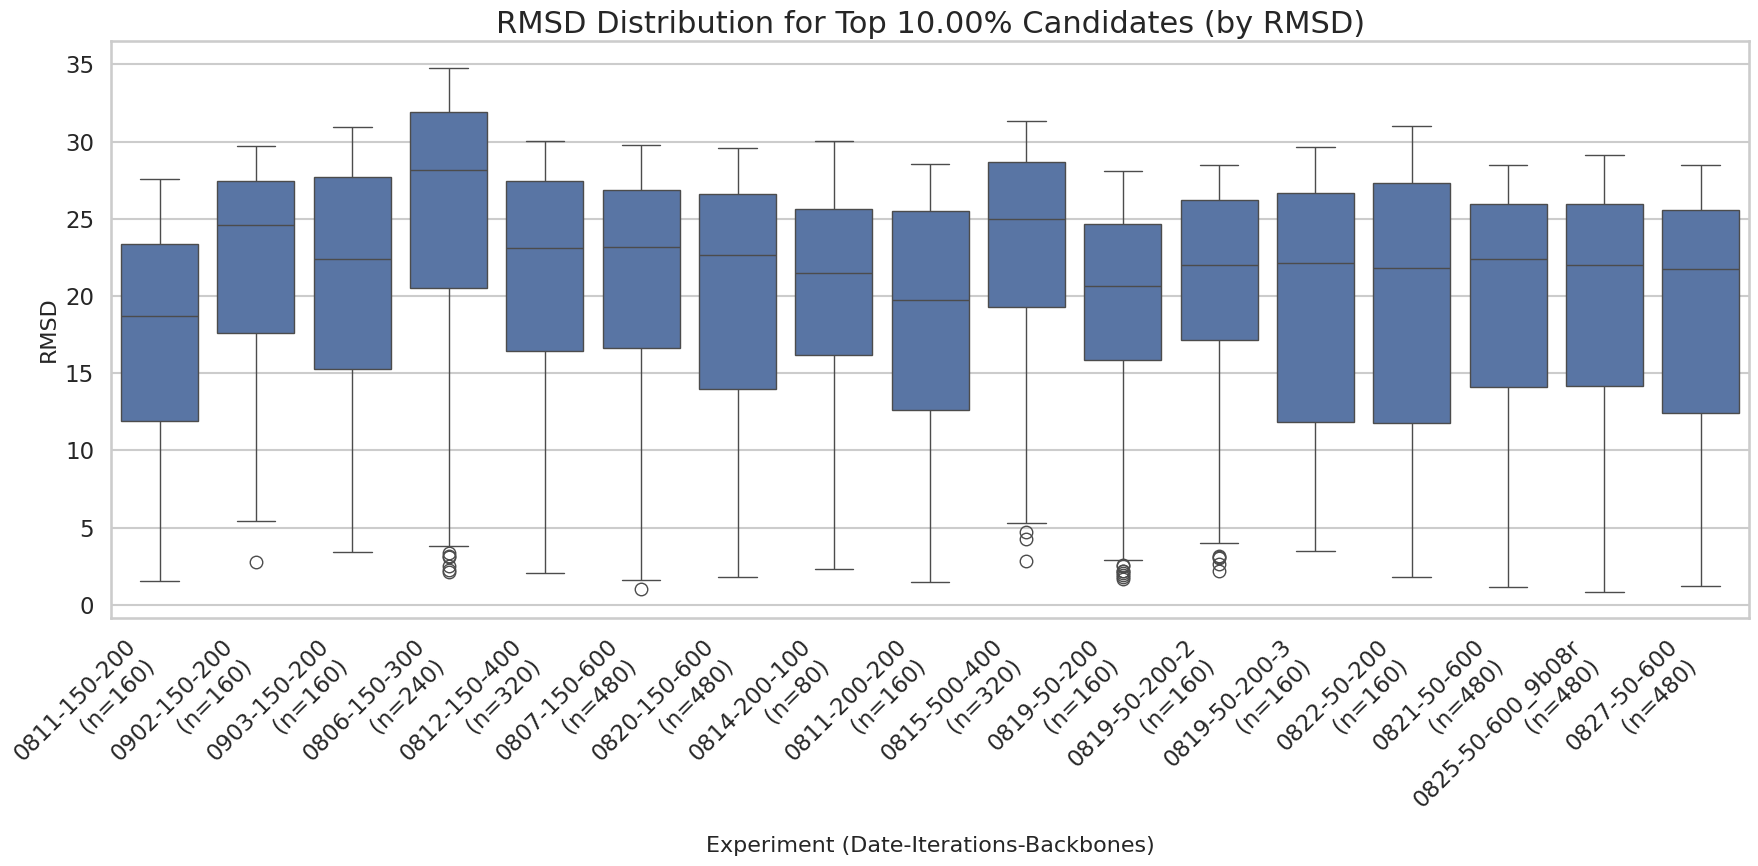

/tmp/ipykernel_556628/4192487576.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_ipae.set_xticklabels(new_labels)


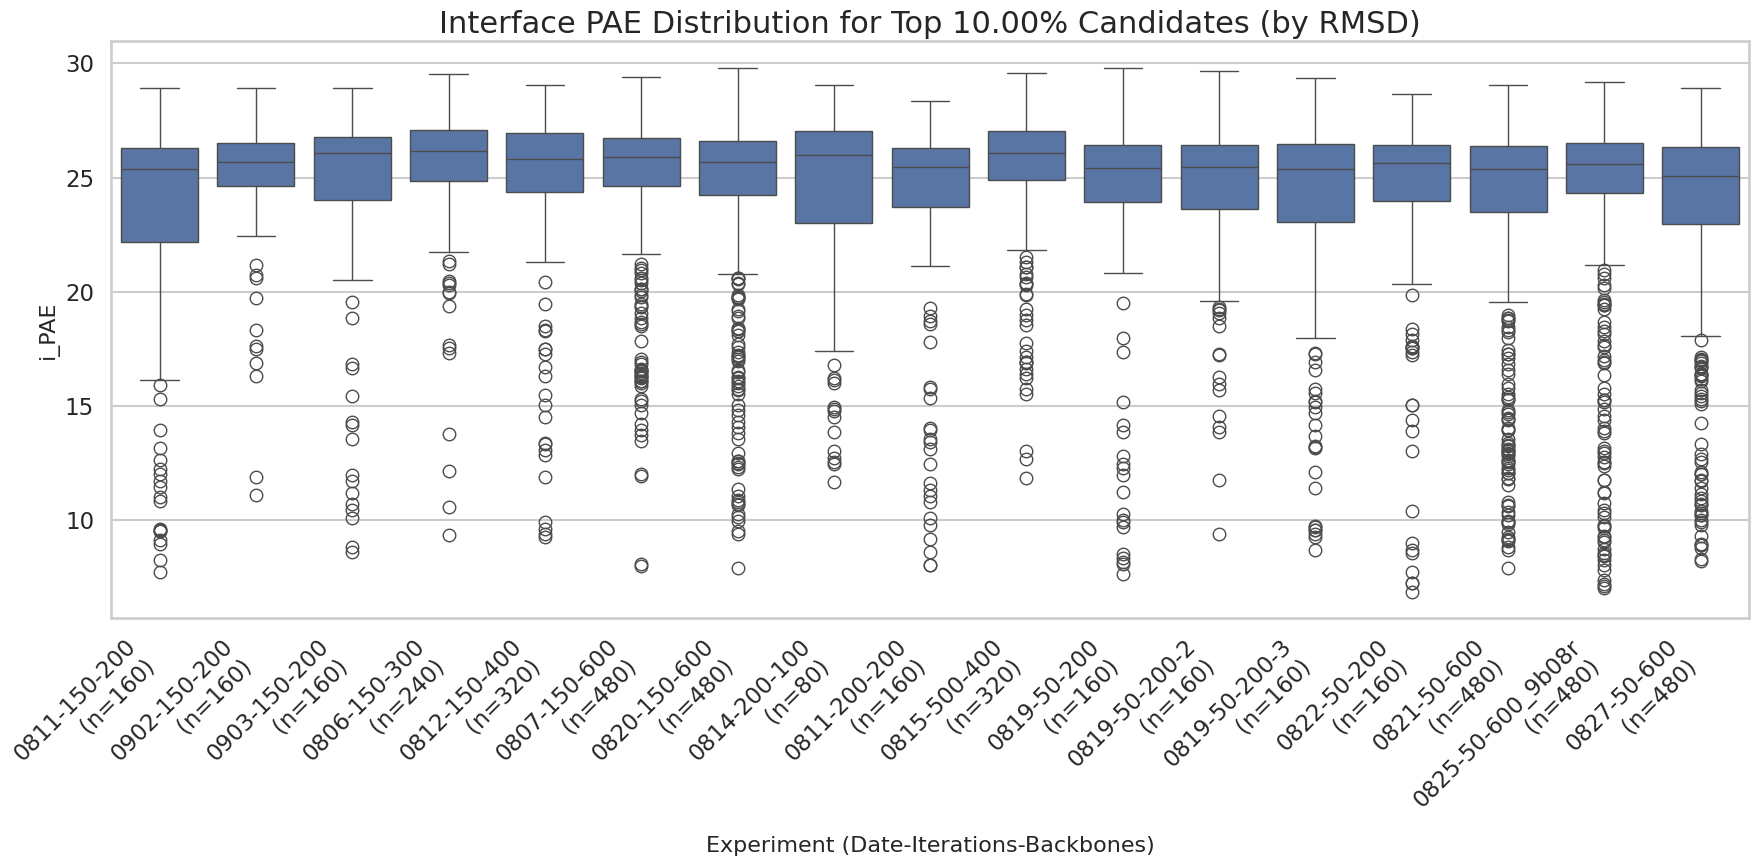

/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
/tmp/ipykernel_556628/4192487576.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

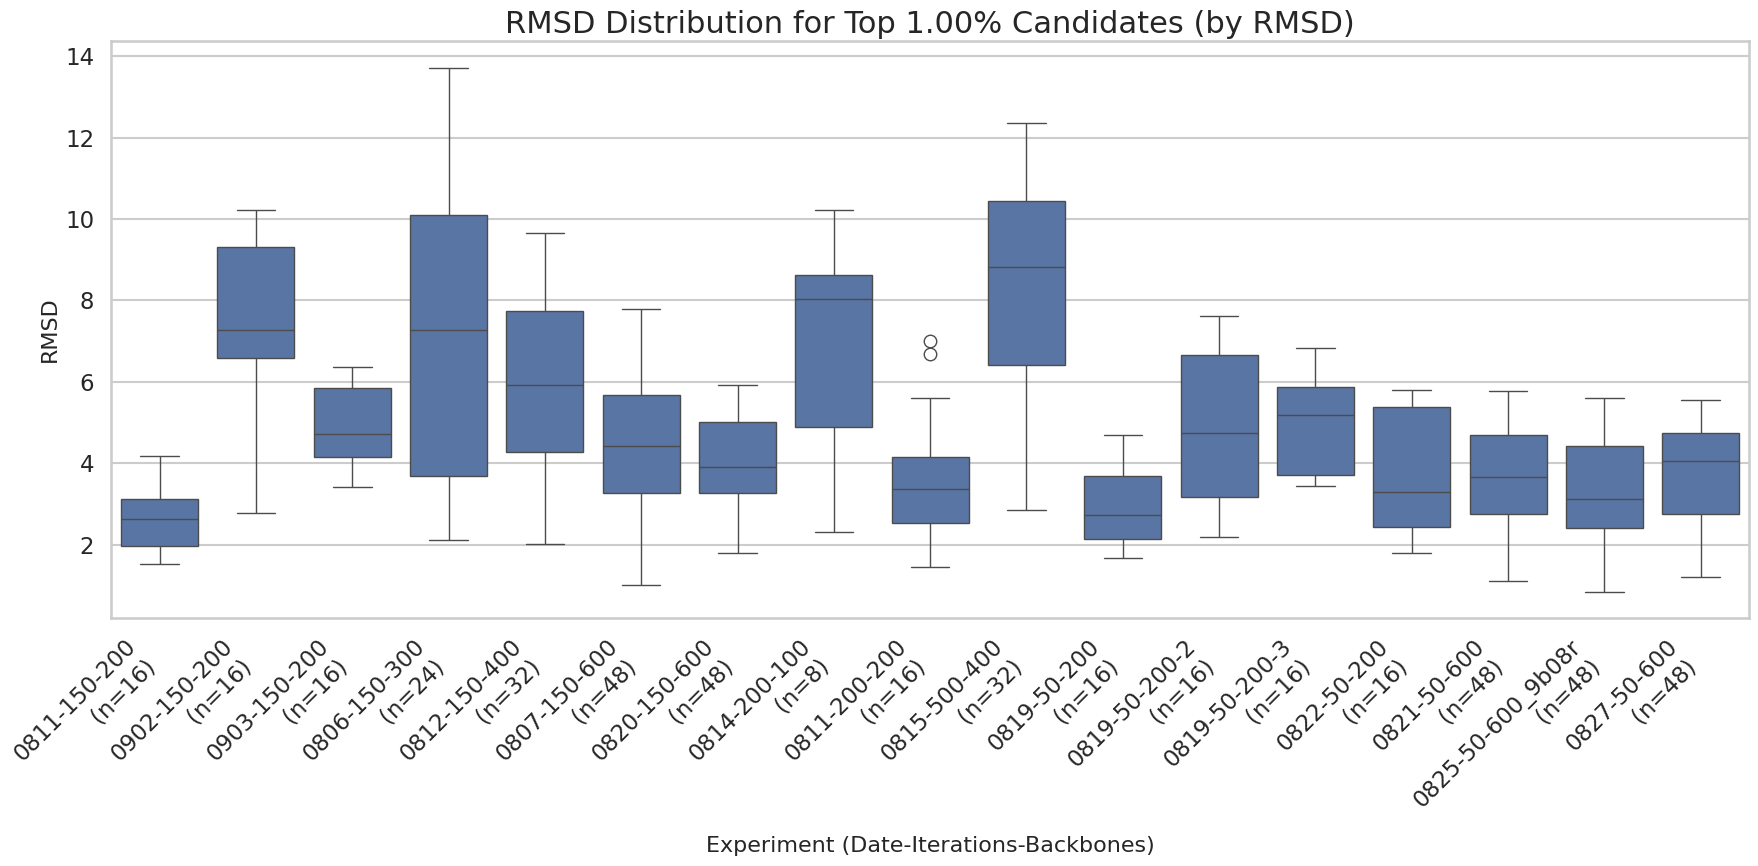

/tmp/ipykernel_556628/4192487576.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_ipae.set_xticklabels(new_labels)


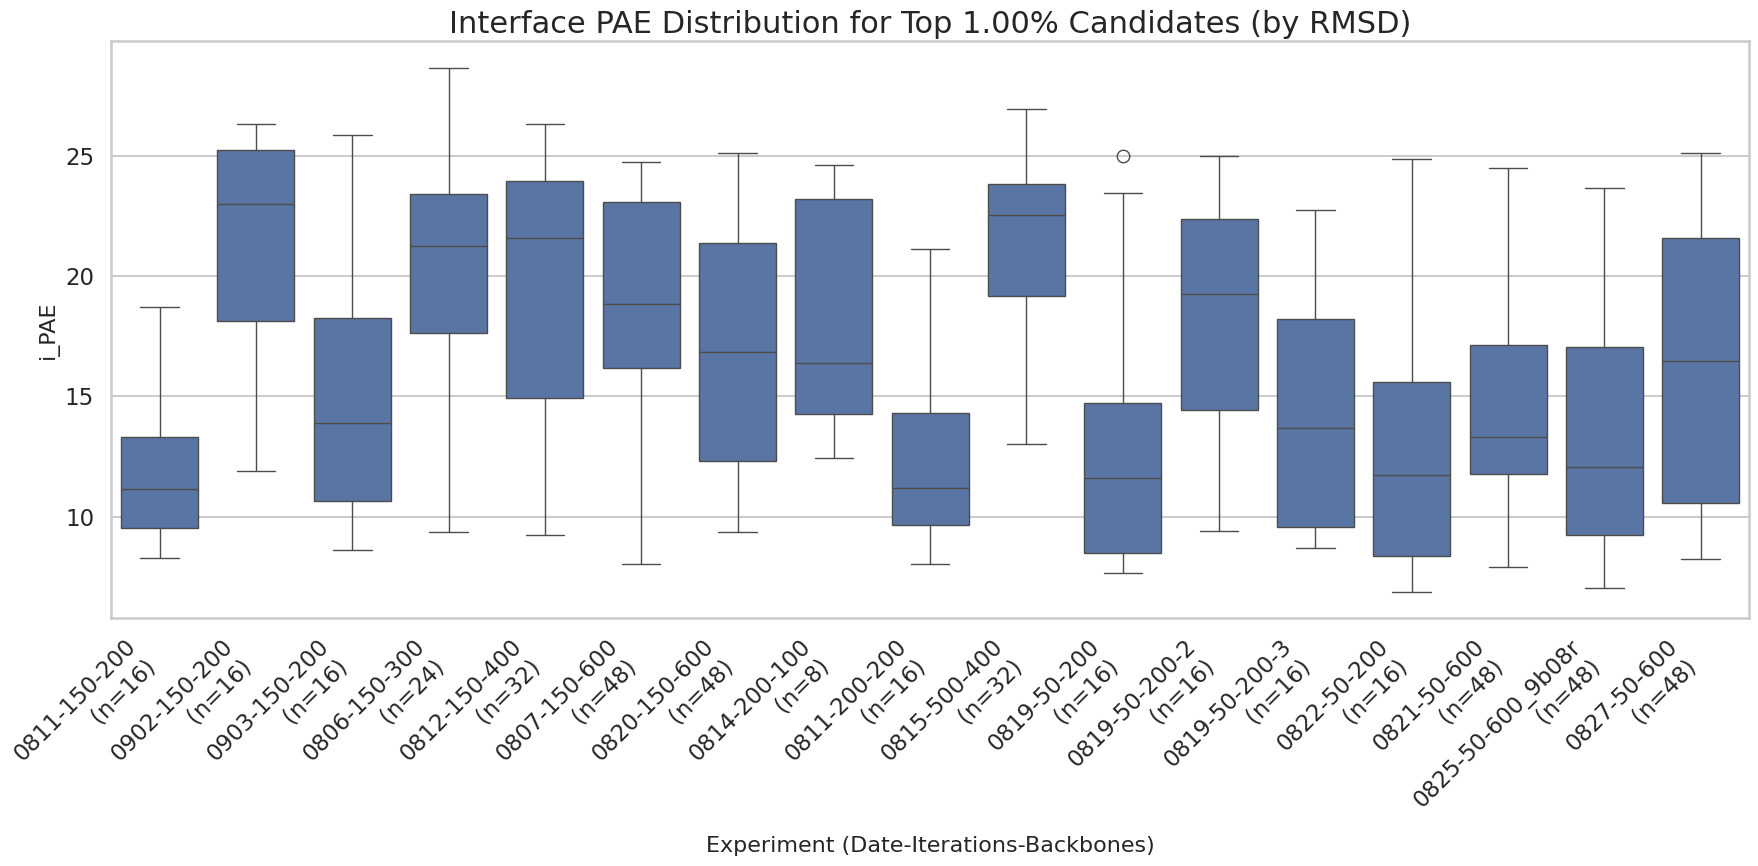

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# CSV를 읽으면 Categorical 정보도 함께 로드됩니다.
master_df = pd.read_csv("all_experiments_summary.csv")
# 'experiment' 컬럼을 다시 Categorical 타입으로 명시해주는 것이 안전합니다.
exp_order_from_file = master_df['experiment'].unique().tolist()
master_df['experiment'] = pd.Categorical(master_df['experiment'], categories=exp_order_from_file, ordered=True)


# 그래프 스타일 설정
sns.set(style="whitegrid", context="talk")

# 분석할 퍼센타일 목록
percentiles_to_analyze = [1, 0.20, 0.10, 0.01]

for p in percentiles_to_analyze:
    
    def get_top_percent(group, percentile):
        n = int(len(group) * percentile)
        if n < 1: n = 1
        return group.nsmallest(n, 'rmsd')

    top_df = master_df.groupby('experiment', group_keys=False).apply(lambda g: get_top_percent(g, p))
    
    # --- ✨ 여기가 수정된 부분입니다 ✨ ---
    # 데이터에 저장된 순서를 그대로 사용합니다.
    # .cat.categories로 전체 카테고리 순서를 가져옵니다.
    order = top_df['experiment'].cat.categories.tolist()
    # ------------------------------------

    counts = top_df['experiment'].value_counts()
    # 일부 실험 데이터가 필터링되어 없을수도 있으므로 .get(name, 0)을 사용합니다.
    new_labels = [f"{name}\n(n={counts.get(name, 0)})" for name in order]

    # ------------------ 시각화 ------------------
    
    title_suffix = f"for Top {p*100:.2f}% Candidates (by RMSD)"
    
    plt.figure(figsize=(18, 9))
    ax_rmsd = sns.boxplot(x='experiment', y='rmsd', data=top_df, order=order)
    ax_rmsd.set_xticklabels(new_labels)
    
    plt.title(f'RMSD Distribution {title_suffix}', fontsize=22)
    plt.xlabel('Experiment (Date-Iterations-Backbones)', fontsize=16)
    plt.ylabel('RMSD', fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 9))
    ax_ipae = sns.boxplot(x='experiment', y='i_pae', data=top_df, order=order)
    ax_ipae.set_xticklabels(new_labels)

    plt.title(f'Interface PAE Distribution {title_suffix}', fontsize=22)
    plt.xlabel('Experiment (Date-Iterations-Backbones)', fontsize=16)
    plt.ylabel('i_PAE', fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

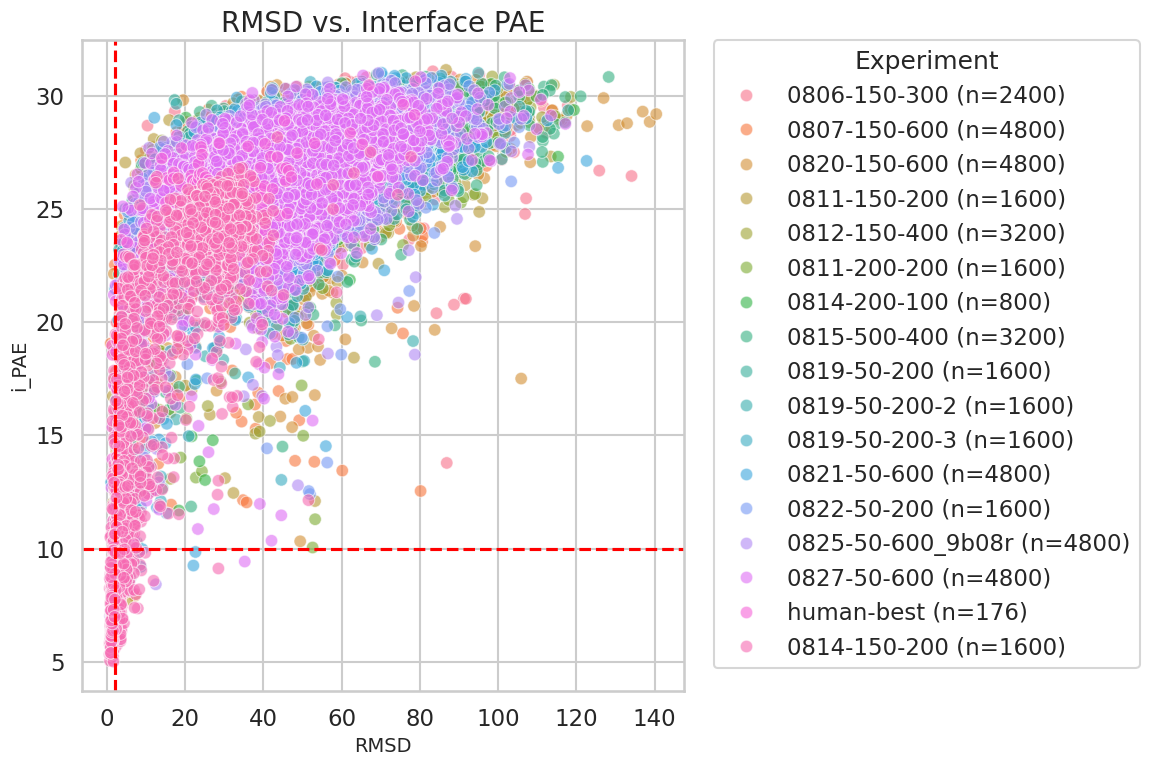

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 이 부분은 이미 실행되었다고 가정합니다 ---
# master_df = pd.read_csv("all_experiments_summary.csv")
# -----------------------------------------

# <<< ✨ 1단계: 범례에 사용할 'n' 개수 계산 및 새 라벨 생성 ✨ >>>
#    - 각 실험별 전체 데이터 개수를 셉니다.
counts = master_df['experiment'].value_counts()
#    - "실험이름 (n=개수)" 형식의 새 라벨을 포함하는 새로운 컬럼을 만듭니다.
#      .map()을 사용하면 각 'experiment' 이름에 해당하는 개수를 쉽게 찾아 새 라벨을 만들 수 있습니다.
master_df['experiment_with_n'] = master_df['experiment'].map(lambda name: f"{name} (n={counts[name]})")


# <<< ✨ 2단계: 새로 만든 라벨을 기준으로 Scatter Plot 그리기 ✨ >>>
plt.figure(figsize=(12, 8))
# hue 옵션에 새로 만든 'experiment_with_n' 컬럼을 사용합니다.
sns.scatterplot(x='rmsd', y='i_pae', hue='experiment_with_n', data=master_df, alpha=0.6)

# 성공 기준으로 여겨지는 구간 표시 (예: RMSD < 2, i_PAE < 10)
plt.axvline(x=2, color='red', linestyle='--')
plt.axhline(y=10, color='red', linestyle='--')

plt.title('RMSD vs. Interface PAE', fontsize=20)
plt.xlabel('RMSD', fontsize=14)
plt.ylabel('i_PAE', fontsize=14)

# 범례 제목을 깔끔하게 'Experiment'로 설정
plt.legend(title='Experiment', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout() # 범례가 잘리지 않도록 레이아웃 조정
plt.show()

/tmp/ipykernel_556628/3980485740.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_counts = successful_designs.groupby('experiment').size().reset_index(name='success_count')
/tmp/ipykernel_556628/3980485740.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = master_df.groupby('experiment').size().reset_index(name='total_count')
/tmp/ipykernel_556628/3980485740.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='experiment', y

--- 실험별 성공률 요약 ---
           experiment  total_count  success_count  success_rate (%)
10        0819-50-200         1600              3              0.19
15  0825-50-600_9b08r         4800              7              0.15
3        0811-150-200         1600              1              0.06
14        0822-50-200         1600              1              0.06
7        0811-200-200         1600              1              0.06
16        0827-50-600         4800              2              0.04
1        0807-150-600         4800              1              0.02
13        0821-50-600         4800              0              0.00
12      0819-50-200-3         1600              0              0.00
11      0819-50-200-2         1600              0              0.00
0        0806-150-300         2400              0              0.00
9        0815-500-400         3200              0              0.00
6        0903-150-200         1600              0              0.00
5        0902-150-200        

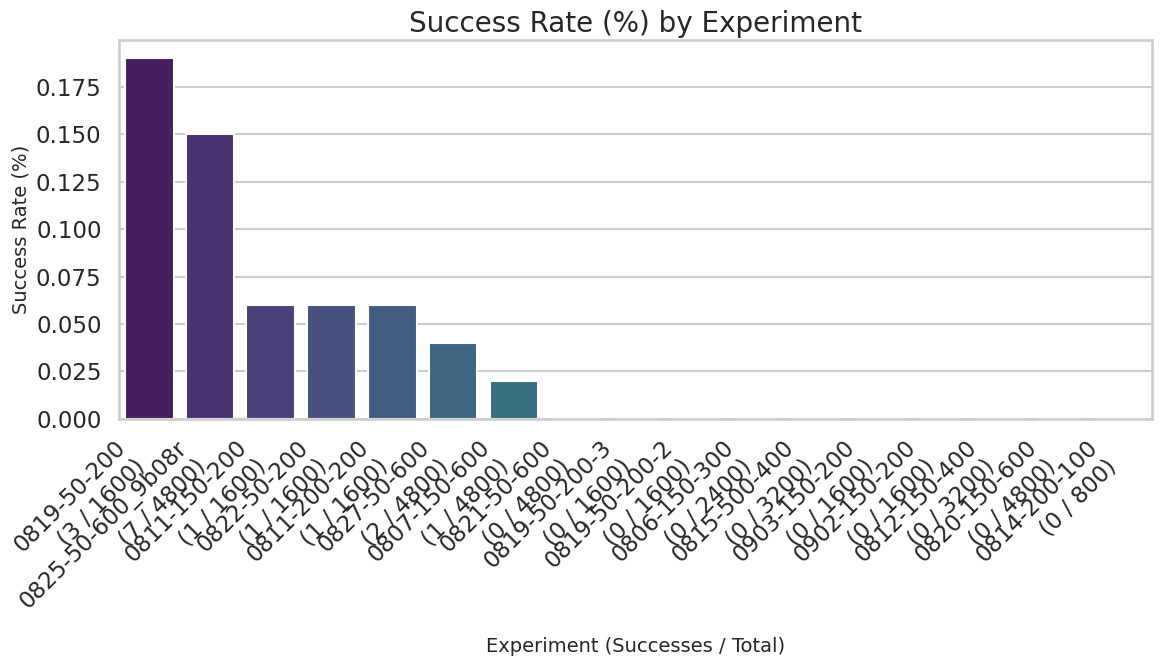

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 이 부분은 이미 실행되었다고 가정합니다 ---
# master_df = pd.read_csv("all_experiments_summary.csv")
# -----------------------------------------

# 1. 성공 기준 정의
successful_designs = master_df[(master_df['rmsd'] < 2) & (master_df['i_pae'] < 10)]

# 2. 실험별 성공 개수 계산
success_counts = successful_designs.groupby('experiment').size().reset_index(name='success_count')

# 3. 실험별 전체 시도 개수 계산
total_counts = master_df.groupby('experiment').size().reset_index(name='total_count')

# 4. 데이터 병합 및 성공률 계산
# 1. merge만 먼저 실행합니다.
summary_table = pd.merge(total_counts, success_counts, on='experiment', how='left')

# 2. 'success_count' 컬럼만 골라서 타입을 숫자로 바꾸고, 빈칸(NaN)을 0으로 채웁니다.
summary_table['success_count'] = pd.to_numeric(summary_table['success_count']).fillna(0).astype(int)
summary_table['success_rate (%)'] = (summary_table['success_count'] / summary_table['total_count'] * 100).round(2)

# 성공률 높은 순으로 정렬
summary_table = summary_table.sort_values(by='success_rate (%)', ascending=False)

print("--- 실험별 성공률 요약 ---")
print(summary_table)


# *************************************************************** #
# <<< ✨ 요청하신 기능: x축 라벨에 성공/전체 개수를 추가합니다. ✨ >>>
#
# 5. x축에 사용할 새 라벨 생성
#    - summary_table의 각 행을 순회하며 "실험이름\n(성공개수/전체개수)" 형식으로 라벨을 만듭니다.
new_labels = [f"{row.experiment}\n({int(row.success_count)} / {int(row.total_count)})" 
              for index, row in summary_table.iterrows()]
# *************************************************************** #


# 6. 성공률 막대그래프로 시각화
plt.figure(figsize=(12, 7))

# ✨ order 옵션을 추가해 데이터프레임의 정렬 순서를 그대로 사용하도록 설정
ax = sns.barplot(x='experiment', y='success_rate (%)', data=summary_table, palette='viridis',
                 order=summary_table['experiment'])

# 위에서 만든 새 라벨을 x축에 적용합니다.
ax.set_xticklabels(new_labels, rotation=45, ha='right')

plt.title('Success Rate (%) by Experiment', fontsize=20)
plt.xlabel('Experiment (Successes / Total)', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_556628/2608271194.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='experiment', y='rmsd', data=master_df, palette='muted')


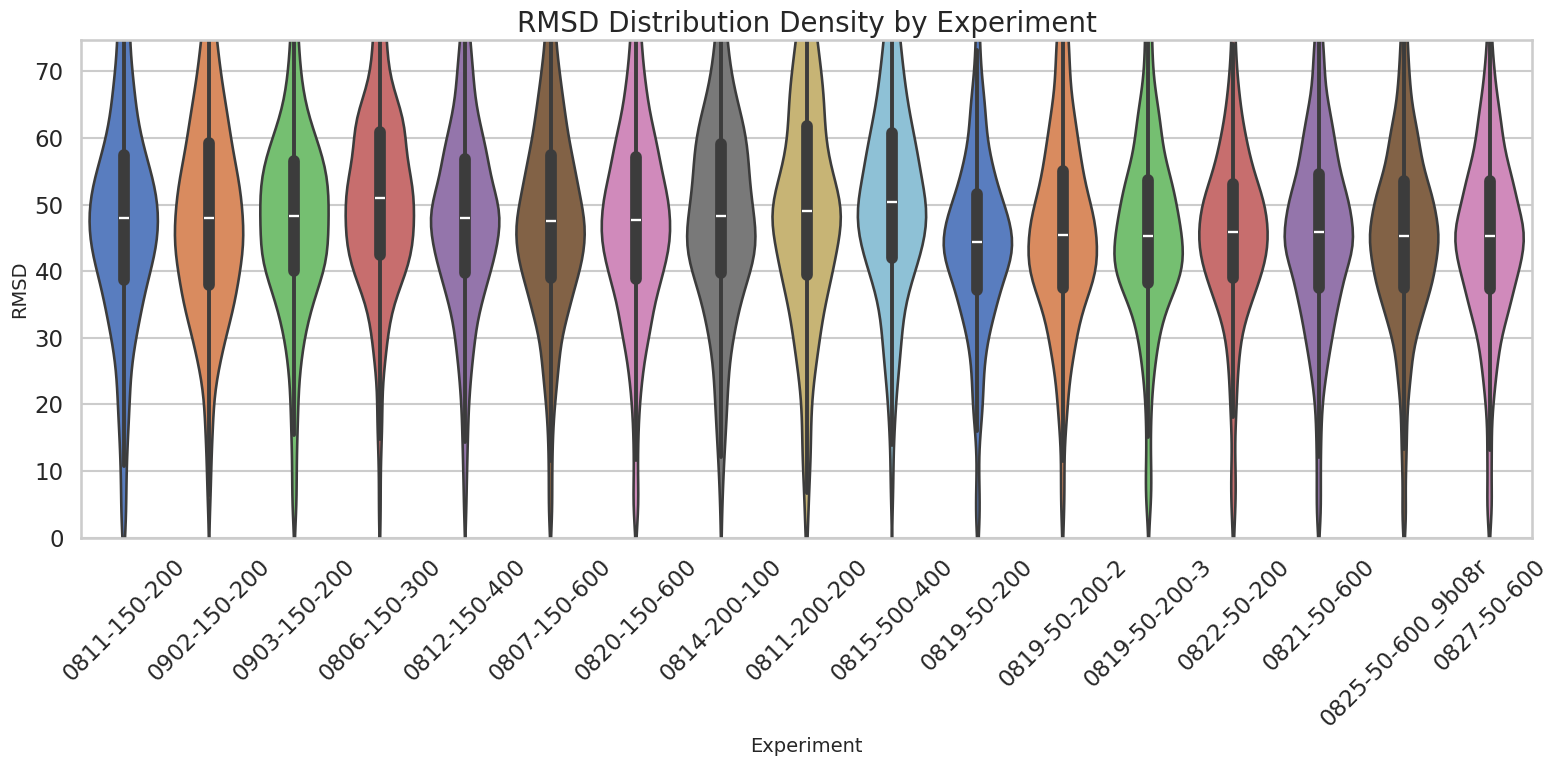

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin Plot으로 RMSD 분포의 모양 비교
plt.figure(figsize=(16, 8))
sns.violinplot(x='experiment', y='rmsd', data=master_df, palette='muted')
plt.title('RMSD Distribution Density by Experiment', fontsize=20)
plt.xlabel('Experiment', fontsize=14)
plt.ylabel('RMSD', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, master_df['rmsd'].quantile(0.95)) # 상위 5% 이상값은 제외하고 그려서 분포를 더 자세히 보기
plt.tight_layout()
plt.show()

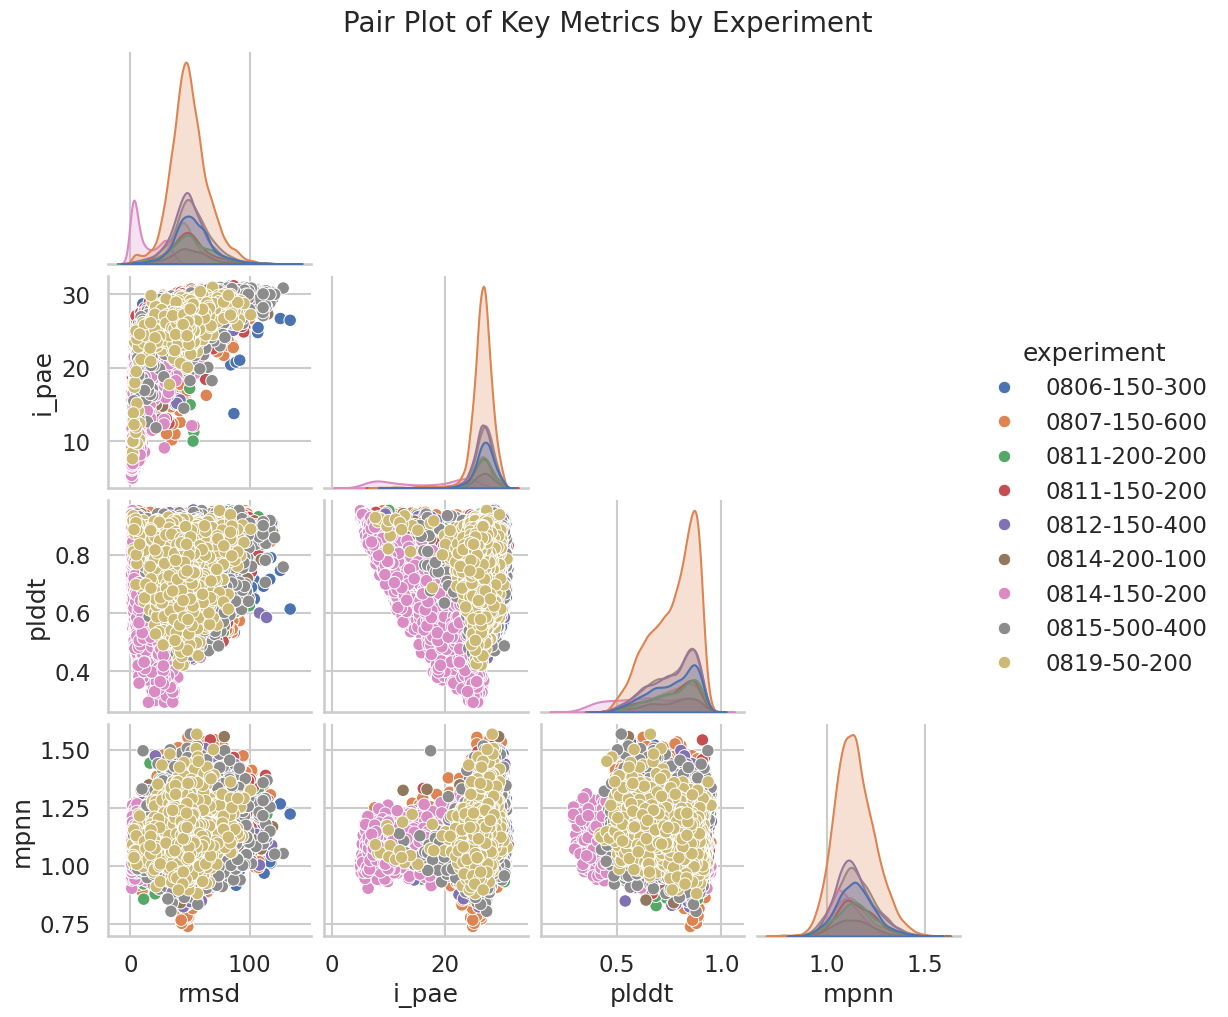

In [27]:
# 분석할 숫자형 컬럼 선택
metrics_to_plot = ['rmsd', 'i_pae', 'plddt', 'mpnn', 'experiment']
subset_df = master_df[metrics_to_plot]

# Pair Plot 생성
# corner=True 옵션은 중복되는 위쪽 삼각형을 그리지 않아 깔끔합니다.
sns.pairplot(subset_df, hue='experiment', corner=True)
plt.suptitle('Pair Plot of Key Metrics by Experiment', y=1.02, fontsize=20)
plt.show()

/tmp/ipykernel_556628/463158259.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_sequences_per_exp = master_df.groupby('experiment')[sequence_column_name].agg(''.join).reset_index()


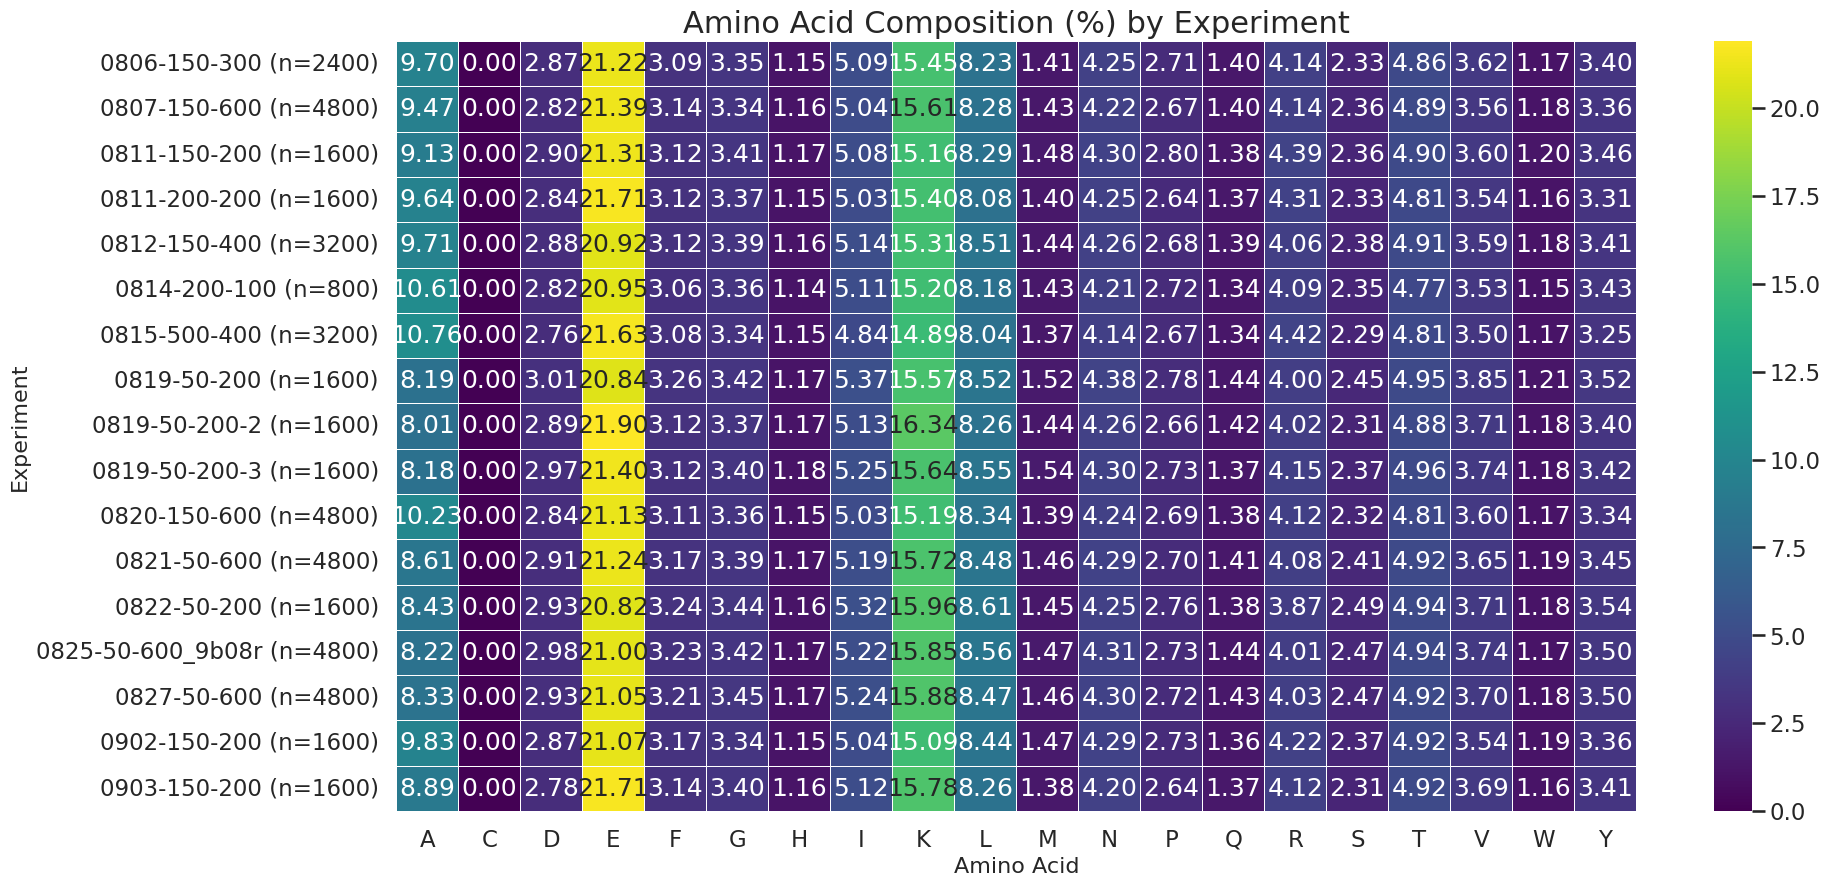

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# --- 이 부분은 이미 실행되었다고 가정합니다 ---
# master_df = pd.read_csv("all_experiments_summary.csv")
# -----------------------------------------

# 1단계: 각 실험별로 모든 서열을 하나의 긴 문자열로 합치기
sequence_column_name = 'seq' 

try:
    all_sequences_per_exp = master_df.groupby('experiment')[sequence_column_name].agg(''.join).reset_index()

    # 2단계: 각 실험의 아미노산 조성(비율) 계산하기
    results = []
    for index, row in all_sequences_per_exp.iterrows():
        experiment_name = row['experiment']
        total_sequence = row[sequence_column_name]
        total_length = len(total_sequence)
        
        aa_counts = Counter(total_sequence)
        
        for aa in "ACDEFGHIKLMNPQRSTVWY":
            frequency = (aa_counts.get(aa, 0) / total_length) * 100
            results.append({
                'experiment': experiment_name,
                'amino_acid': aa,
                'frequency (%)': frequency
            })

    # 3단계: 결과를 히트맵에 적합한 DataFrame 형태로 변환(피봇)
    freq_df = pd.DataFrame(results)
    heatmap_data = freq_df.pivot(index='experiment', columns='amino_acid', values='frequency (%)')
    
    # *************************************************************** #
    # <<< ✨ 요청하신 기능: y축 라벨에 데이터 개수(n)를 추가합니다. ✨ >>>
    #
    # 4단계: y축 라벨에 사용할 'n' 개수 계산 및 새 라벨 생성
    #    - master_df에서 각 실험별 전체 디자인 개수를 셉니다.
    total_counts = master_df['experiment'].value_counts()
    #    - 현재 히트맵 데이터의 인덱스(실험 이름)를 가져옵니다.
    original_labels = heatmap_data.index
    #    - "실험이름 (n=개수)" 형식의 새 라벨 목록을 만듭니다.
    new_labels = [f"{name} (n={total_counts[name]})" for name in original_labels]
    #    - 히트맵 데이터의 인덱스를 새로 만든 라벨로 교체합니다.
    heatmap_data.index = new_labels
    # *************************************************************** #

    # 5단계: 히트맵 시각화
    plt.figure(figsize=(20, 10))
    sns.heatmap(
        heatmap_data, 
        cmap='viridis',
        annot=True,
        fmt='.2f',
        linewidths=.5
    )

    plt.title('Amino Acid Composition (%) by Experiment', fontsize=22)
    plt.xlabel('Amino Acid', fontsize=16)
    plt.ylabel('Experiment', fontsize=16)
    plt.show()

except KeyError:
    print(f"'{sequence_column_name}' 컬럼을 찾을 수 없습니다!")
    print("\n사용 가능한 컬럼 목록:")
    print(master_df.columns.tolist())

총 46400개의 디자인 중 16개의 성공적인 후보를 찾았습니다.


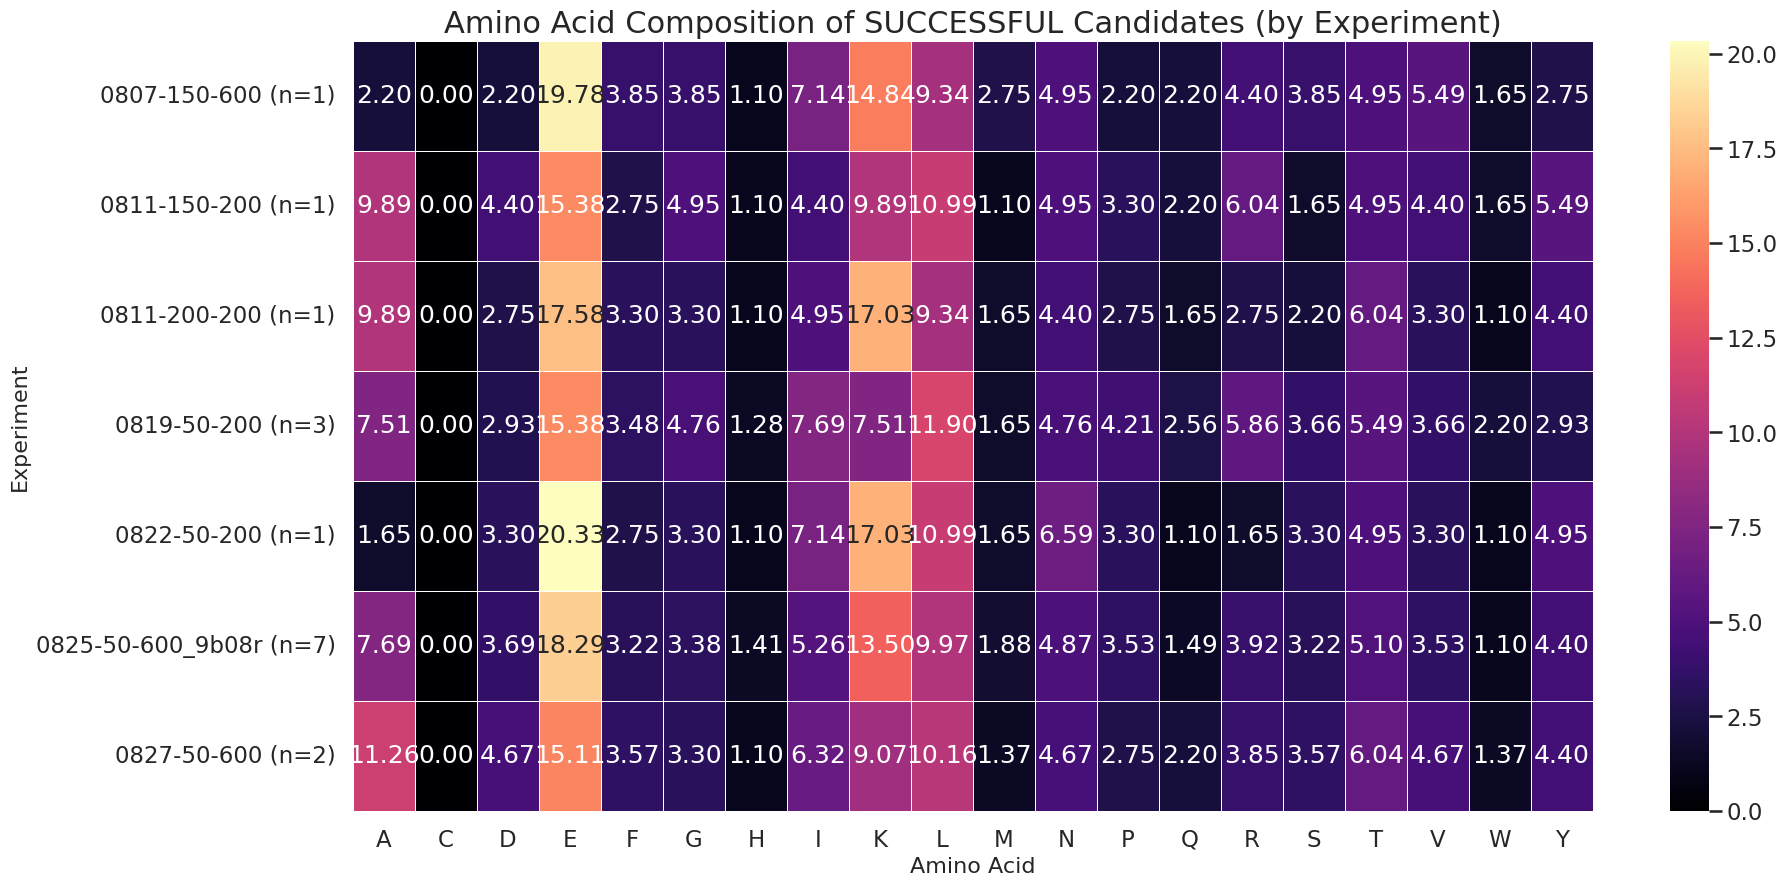

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# --- 이 부분은 이미 실행되었다고 가정합니다 ---
# master_df = pd.read_csv("all_experiments_summary.csv")
# -----------------------------------------

# 1단계: 성공 기준을 만족하는 데이터만 필터링
successful_df = master_df[(master_df['rmsd'] < 2) & (master_df['i_pae'] < 10)].copy()

print(f"총 {len(master_df)}개의 디자인 중 {len(successful_df)}개의 성공적인 후보를 찾았습니다.")

# 2단계: '성공 후보군' 내에서 실험별로 서열 합치기
sequence_column_name = 'seq'
success_sequences_per_exp = successful_df.groupby('experiment', observed=False)[sequence_column_name].agg(''.join).reset_index()

# 3단계: 비율 계산
results_success_exp = [] # 결과를 담을 리스트를 한번만 생성
for index, row in success_sequences_per_exp.iterrows():
    experiment_name = row['experiment']
    total_sequence = row[sequence_column_name]
    total_length = len(total_sequence)
    
    # 서열 길이가 0보다 클 때만 계산을 수행
    if total_length > 0:
        aa_counts = Counter(total_sequence)
        
        # for문 전체가 if문 안쪽에 위치해야 함
        for aa in "ACDEFGHIKLMNPQRSTVWY":
            frequency = (aa_counts.get(aa, 0) / total_length) * 100
            results_success_exp.append({
                'experiment': experiment_name,
                'amino_acid': aa,
                'frequency (%)': frequency
            })

# 4단계: 히트맵 데이터 준비
freq_df_success_exp = pd.DataFrame(results_success_exp)
heatmap_data_success_exp = freq_df_success_exp.pivot(index='experiment', columns='amino_acid', values='frequency (%)')


# *************************************************************** #
# <<< ✨ 요청하신 기능: y축 라벨에 데이터 개수(n)를 추가합니다. ✨ >>>
#
# 5단계: y축 라벨에 사용할 'n' 개수 계산 및 새 라벨 생성
#    - successful_df에서 각 실험별 성공 디자인 개수를 셉니다.
success_counts = successful_df['experiment'].value_counts()
#    - 현재 히트맵 데이터의 인덱스(실험 이름)를 가져옵니다.
original_labels = heatmap_data_success_exp.index
#    - "실험이름 (n=개수)" 형식의 새 라벨 목록을 만듭니다.
new_labels = [f"{name} (n={success_counts[name]})" for name in original_labels]
#    - 히트맵 데이터의 인덱스를 새로 만든 라벨로 교체합니다.
heatmap_data_success_exp.index = new_labels
# *************************************************************** #


# 6단계: 히트맵 시각화
plt.figure(figsize=(20, 10))
# 이제 히트맵을 그리면 y축에 자동으로 새 라벨이 적용됩니다.
sns.heatmap(heatmap_data_success_exp, cmap='magma', annot=True, fmt='.2f', linewidths=.5)
plt.title('Amino Acid Composition of SUCCESSFUL Candidates (by Experiment)', fontsize=22)
plt.xlabel('Amino Acid', fontsize=16)
plt.ylabel('Experiment', fontsize=16)
plt.show()